<a href="https://colab.research.google.com/github/sathu0622/AI-Powered-System-for-Voice-Based-Resource-Type-Summarization-of-Historical-Content-for-VIS/blob/Resource_Type_Detection/Resource_Type_Detection_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Class weights: {0: np.float64(1.1382113821138211), 1: np.float64(0.7415254237288136), 2: np.float64(1.2939001848428835)}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 493s 4s/step - accuracy: 0.6632 - loss: 0.7639 - val_accuracy: 0.8688 - val_loss: 0.3190 - learning_rate: 0.0010
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.9006 - loss: 0.2389 - val_accuracy: 0.8916 - val_loss: 0.2686 - learning_rate: 0.0010
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.9161 - loss: 0.2079 - val_accuracy: 0.8574 - val_loss: 0.3301 - learning_rate: 0.0010
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.9306 - loss: 0.1808 - val_accuracy: 0.8650 - val_loss: 0.3209 - learning_rate: 0.0010
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.9355 - loss: 0.1510 - val_accuracy: 0.8764 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - a

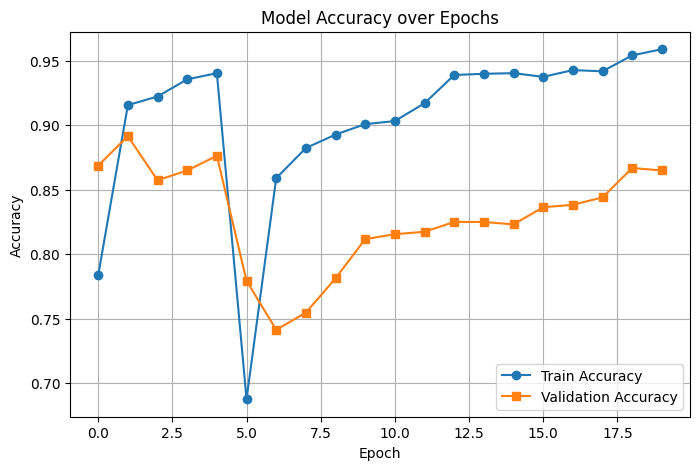

💾 Model saved to: /content/drive/MyDrive/Image/book_magazine_newspaper_model_super_finetuned2.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# -----------------------------
# Settings
# -----------------------------
dataset_dir = "/content/drive/MyDrive/Image_JPG"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 20

# -----------------------------
# Get all image paths and labels
# -----------------------------
all_images = glob.glob(os.path.join(dataset_dir, "*", "*.jpg"))
class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
label2idx = {name: i for i, name in enumerate(class_names)}
all_labels_idx = [label2idx[os.path.basename(os.path.dirname(p))] for p in all_images]

# -----------------------------
# Stratified train/validation split
# -----------------------------
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_images, all_labels_idx, test_size=0.2, random_state=SEED, stratify=all_labels_idx
)

# -----------------------------
# Function to load and preprocess images
# -----------------------------
def preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

# -----------------------------
# Build tf.data datasets
# -----------------------------
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# -----------------------------
# Compute class weights
# -----------------------------
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_values))
print("Class weights:", class_weights)

# -----------------------------
# Data augmentation
# -----------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

# -----------------------------
# Load MobileNetV2 base
# -----------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

# -----------------------------
# Build full model
# -----------------------------
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# -----------------------------
# Compile model
# -----------------------------
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# -----------------------------
# Train top layers
# -----------------------------
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# -----------------------------
# Fine-tune last layers of MobileNetV2
# -----------------------------
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    initial_epoch=history.epoch[-1]+1,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# -----------------------------
# Plot accuracy
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'],
         label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'],
         label='Validation Accuracy', marker='s')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Save model
# -----------------------------
model_path = "/content/drive/MyDrive/Image/book_magazine_newspaper_model_super_finetuned2.keras"
model.save(model_path)
print(f"💾 Model saved to: {model_path}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


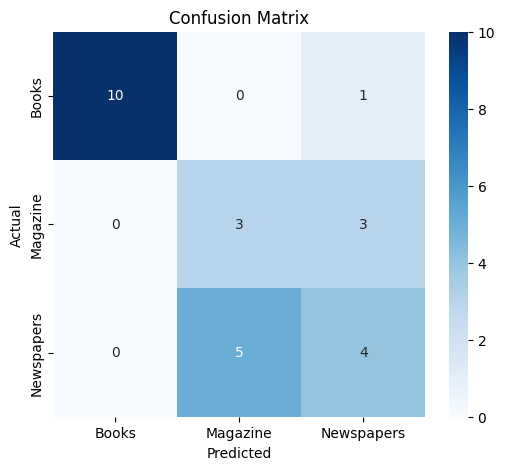


Classification Report:

              precision    recall  f1-score   support

       Books       1.00      0.91      0.95        11
    Magazine       0.38      0.50      0.43         6
  Newspapers       0.50      0.44      0.47         9

    accuracy                           0.65        26
   macro avg       0.62      0.62      0.62        26
weighted avg       0.68      0.65      0.66        26


✅ Prediction Summary:
Books: 10 images
Magazine: 8 images
Newspapers: 8 images


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report

# -----------------------------
# Settings
# -----------------------------
IMG_SIZE = (224, 224)
class_names = ['Books', 'Magazine', 'Newspapers']  # same order as training
model_path = "/content/drive/MyDrive/Image/book_magazine_newspaper_model_finetuned.keras"

# Folder containing test images
test_folder = "/content/drive/MyDrive/Image_JPG/Test"  # organize subfolders: Books, Magazine, NewsPapers

# -----------------------------
# Load model
# -----------------------------
model = load_model(model_path)

# -----------------------------
# Function to predict a single image
# -----------------------------
def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]
    confidence = np.max(pred)
    return pred_class, confidence

# -----------------------------
# Collect all test images
# -----------------------------
test_paths = []
true_labels = []

for cls_idx, cls_name in enumerate(class_names):
    cls_folder = os.path.join(test_folder, cls_name)
    for file in os.listdir(cls_folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            test_paths.append(os.path.join(cls_folder, file))
            true_labels.append(cls_name)

# -----------------------------
# Predict all images
# -----------------------------
pred_labels = []
pred_confidence = []

for path in test_paths:
    cls, conf = predict_image(path)
    pred_labels.append(cls)
    pred_confidence.append(conf)

# -----------------------------
# Confusion matrix
# -----------------------------
cm = confusion_matrix(true_labels, pred_labels, labels=class_names)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# Classification report
# -----------------------------
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names))

# -----------------------------
# Summary of predictions
# -----------------------------
summary = {cls:0 for cls in class_names}
for cls in pred_labels:
    summary[cls] += 1

print("\n✅ Prediction Summary:")
for cls, count in summary.items():
    print(f"{cls}: {count} images")
